In [1]:
import skimage
import skimage.transform
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Dlib face detector
detector = dlib.get_frontal_face_detector()

# Dlib landmarks predictor
predictor = dlib.shape_predictor('./model/shape_predictor_68_face_landmarks.dat')

def _detect_face_dlib(image):
    """
    Function to detect faces in the input image with dlib
    :param image: grayscale image with face(s)
    :return: dlib regtangles object with detected face regions
    """
    return detector(image, 1)

def _shape_to_array(shape):
    """
    Function to convert dlib shape object to array
    :param shape:
    :return:
    """
    return np.array([[p.x, p.y] for p in shape.parts()], dtype=float)

def _landmark_convert(landmark):
    return [(x,y) for x,y in landmark]

def find_landmarks(image, predictor, visualise=False):
    """
    Function to find face landmarks (coordinates of nose, eyes, mouth etc) with dlib face landmarks predictor.
    :param image: greyscale image which contains face
    :param predictor: dlib object, shape predictor
    :param visualise: flag to draw detected landmarks on top of the face

    :return: dlib shape object with coordinates for 68 facial landmarks
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dets = _detect_face_dlib(image)

    try:
        shape = predictor(image, dets[0])
        i = 0
        font = cv2.FONT_HERSHEY_DUPLEX
        image_copy = image.copy()
        if visualise:
            while i < shape.num_parts:
                p = shape.part(i)
                cv2.circle(image_copy, (p.x, p.y), 2, (0, 255, 0), 2)
                cv2.putText(image_copy, str(i), (p.x +1 , p.y + 1 ), font, 0.3, (255, 255, 255), 1)
                i += 1
            cv2.imshow('demo',image_copy)
            cv2.waitKey(0)

    except:
        shape = None
    return shape

In [3]:
def face_warp(src_face, src_face_lm, dst_face, dst_face_lm):
    # Helpers
    output_shape = dst_face.shape  # dimensions of our final image (from webcam eg)
    # Get the landmarks/parts for the face.
    try:
        src_face_coord = _shape_to_array(src_face_lm)
        dst_face_coord = _shape_to_array(dst_face_lm)
#         # ignore nose coordinates since I found out the transformed nose looks ugly
#         src_face_coord_without_nose = np.vstack((src_face_coord[:27],src_face_coord[35:]))
#         dst_face_coord_without_nose = np.vstack((dst_face_coord[:27],dst_face_coord[35:]))

        warp_trans = skimage.transform.PiecewiseAffineTransform()
        warp_trans.estimate(dst_face_coord, src_face_coord)
        warped_face = skimage.transform.warp(src_face, warp_trans, output_shape=output_shape)
    except:
        warped_face = dst_face
    return warped_face

In [4]:
img_path1 = './demo/make_up.jpg'
img1 = mpimg.imread(img_path1)
landmark1 = find_landmarks(image=img1,predictor=predictor,visualise=False)

img_path2 = './demo/ariana_grande.jpg'
img2 = mpimg.imread(img_path2)
landmark2 = find_landmarks(image=img2,predictor=predictor,visualise=False)

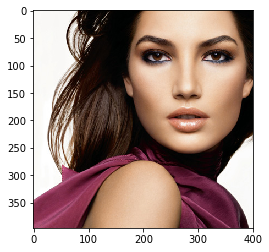

In [5]:
plt.imshow(img1)

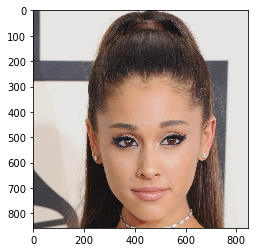

In [6]:
plt.imshow(img2)

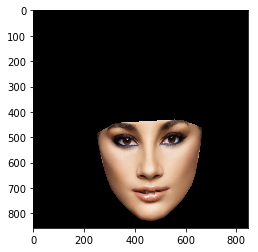

In [7]:
warp_img1 = face_warp(img1, landmark1, img2, landmark2)

plt.imshow(warp_img1)

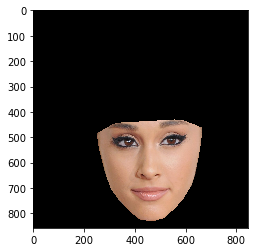

In [8]:
warp_img2 = face_warp(img2, landmark2, img2, landmark2)

plt.imshow(warp_img2)

In [9]:
def _merge_images(img_top, img_bottom, mask=0):
    img_top = skimage.img_as_ubyte(img_top)
    img_bottom = skimage.img_as_ubyte(img_bottom)
    merge_layer = img_top == mask
    img_top[merge_layer] = img_bottom[merge_layer]
    return img_top

In [10]:
COLOUR_CORRECT_BLUR_FRAC = 0.6

def correct_colours(src_face, dst_face, landmarks1):
    landmark_arrary = _shape_to_array(landmark1)
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmark_arrary[36:42], axis=0) -
                              np.mean(landmark_arrary[42:48], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1

    src_face_blur = cv2.GaussianBlur(src_face, (blur_amount, blur_amount), 0)
    dst_face_blur = cv2.GaussianBlur(dst_face, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    index = np.where(dst_face_blur == 0.0)
    dst_face_blur[index] = 0.001

    correct_face =  (dst_face.astype(np.float64) * src_face_blur.astype(np.float64) /
                                                dst_face_blur.astype(np.float64))
    index = np.where(correct_face > 1.0)
    correct_face[index] = 1.0
    return correct_face

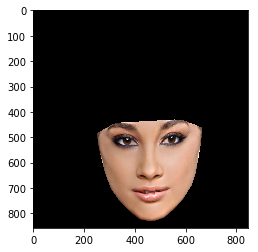

In [11]:
correct_face = correct_colours(warp_img2,warp_img1,landmark1)
plt.imshow(correct_face)

In [12]:
LEFT_MOST_POINTS = list([0,1])
RIGHT_MOST_POINTS = list([15,16])
LEFT_EYE_POINTS = list(range(36, 42))
RIGHT_EYE_POINTS = list(range(42, 48))
LEFT_BROW_POINTS = list(range(17, 22))
RIGHT_BROW_POINTS = list(range(22, 27))
NOSE_POINTS = list(range(27, 35))
MID_NOSE_POINT = list([28])
TOP_LIPS = list(range(48, 55)) + list(reversed(range(60, 65)))
BOTTOM_LIP = list(range(54, 61)) + list(reversed(range(64, 68)))
TOOTH = list(range(60,68))
CHEEK = list(range(0,17))

def draw_convex_hull(im, points, color):
    points = points.astype('int32')
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def draw_polygon(im, points, color):
    pts = [(x,y) for x,y in points]
    cv2.fillPoly(im, np.array([pts], np.int32), color=color)
    
def get_eyes_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)
    landmarks = _shape_to_array(landmarks)
    OVERLAY_POINTS = [
    LEFT_EYE_POINTS + LEFT_BROW_POINTS + 
    RIGHT_EYE_POINTS + RIGHT_BROW_POINTS +
    LEFT_MOST_POINTS + RIGHT_MOST_POINTS + MID_NOSE_POINT,]
    for group in OVERLAY_POINTS:
        draw_convex_hull(im,landmarks[group],color=1)
    im = np.array([im, im, im]).transpose((1, 2, 0))
    return im

def get_mouth_mask(im,landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)
    landmarks = _shape_to_array(landmarks)
    OVERLAY_POINTS = [TOP_LIPS,BOTTOM_LIP,]
    for group in OVERLAY_POINTS:
        draw_convex_hull(im,landmarks[group],color=1)
    im = np.array([im, im, im]).transpose((1, 2, 0))
    return im

def get_tooth_mask(im,landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)
    landmarks = _shape_to_array(landmarks)
    OVERLAY_POINTS = [TOOTH,]
    for group in OVERLAY_POINTS:
        draw_polygon(im,landmarks[group],color=1)
    im = np.array([im, im, im]).transpose((1, 2, 0))
    return im

def get_face_mask(im,landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)
    landmarks = _shape_to_array(landmarks)
    OVERLAY_POINTS = [CHEEK+LEFT_BROW_POINTS+RIGHT_BROW_POINTS,]
    for group in OVERLAY_POINTS:
        draw_convex_hull(im,landmarks[group],color=1)
    im = np.array([im, im, im]).transpose((1, 2, 0))
    return im   

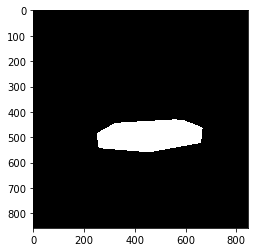

In [13]:
eyes_mask = get_eyes_mask(img2, landmark2)
plt.imshow(eyes_mask)

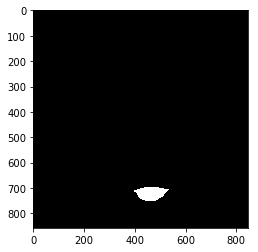

In [14]:
mouth_mask = get_mouth_mask(img2, landmark2)
plt.imshow(mouth_mask)

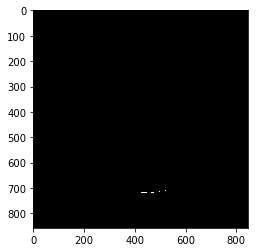

In [15]:
tooth_mask = get_tooth_mask(img2, landmark2)
plt.imshow(tooth_mask)

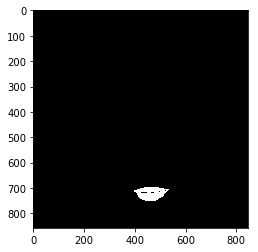

In [16]:
def get_mouth_mask_without_tooth(mouth_mask, tooth_mask):
    return mouth_mask - tooth_mask

mouth_mask_without_tooth = get_mouth_mask_without_tooth(mouth_mask, tooth_mask)
plt.imshow(mouth_mask_without_tooth)

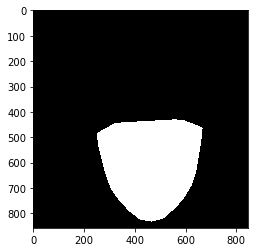

In [17]:
face_mask = get_face_mask(img2, landmark2)
plt.imshow(face_mask)

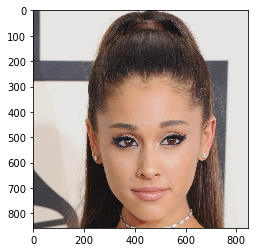

In [18]:
plt.imshow(img2)

C:\Users\Administrator\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


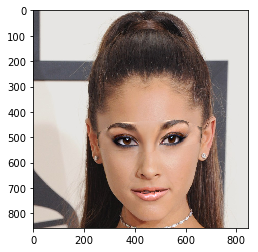

In [19]:
src = img2
obj = (correct_face*eyes_mask).astype('float32') + (correct_face*(mouth_mask_without_tooth)).astype('float32')
merged1 = _merge_images(obj,src)
plt.imshow(merged1)

In [20]:
plt.imsave('./demo/partly_merged.jpg',merged1)

C:\Users\Administrator\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


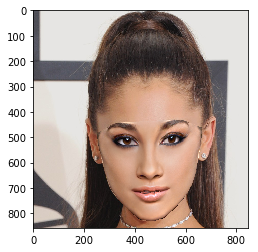

In [21]:
src = img2
obj = (warp_img2*tooth_mask).astype('float32') + (correct_face*(1-tooth_mask)).astype('float32')
merged2 = _merge_images(obj,src)
plt.imshow(merged2)

In [22]:
plt.imsave('./demo/face_merged.jpg',merged2)